In [1]:
import pathlib
import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import random

In [2]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
batch_size = 16

In [5]:
# load the images and masks
dir_images_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/images')
dir_masks_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/masks')
dir_images_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/images')
dir_masks_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/masks')

In [6]:
train_ids = [f.stem for f in dir_images_train.glob("*.jpg")]
test_ids = [f.stem for f in dir_images_test.glob("*.jpg")]

In [7]:
#train_ids = train_ids[:batch_size*10]#*100
#test_ids = test_ids[:batch_size*20]

In [8]:
len(train_ids), len(test_ids)

(762, 182)

In [9]:
class KvasirSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, ids, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            mask_dir (pathlib.Path): Directory with all the masks.
            pca_data (pd.DataFrame): DataFrame containing PCA features.
            ids (list): List of image/mask IDs (without extensions).
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.jpg").convert("RGB"))
        
        mask = np.array(Image.open(self.mask_dir / f"{name}.jpg").convert("L")) / 255
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)


        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)

        return image, mask


In [10]:
# Create datasets with transformations
dataset_train = KvasirSegDataset(dir_images_train, dir_masks_train, train_ids)
dataset_test = KvasirSegDataset(dir_images_test, dir_masks_test, test_ids)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [11]:
for images, masks in train_loader:
    print(images[0].shape)
    print(images[0])
    break

torch.Size([128, 128, 3])
tensor([[[0, 1, 0],
         [0, 1, 0],
         [0, 0, 0],
         ...,
         [1, 0, 2],
         [7, 0, 4],
         [8, 0, 4]],

        [[0, 1, 0],
         [0, 1, 0],
         [0, 0, 0],
         ...,
         [1, 0, 2],
         [6, 0, 4],
         [7, 0, 4]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [1, 0, 2],
         [4, 0, 2],
         [6, 0, 2]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=torch.uint8)


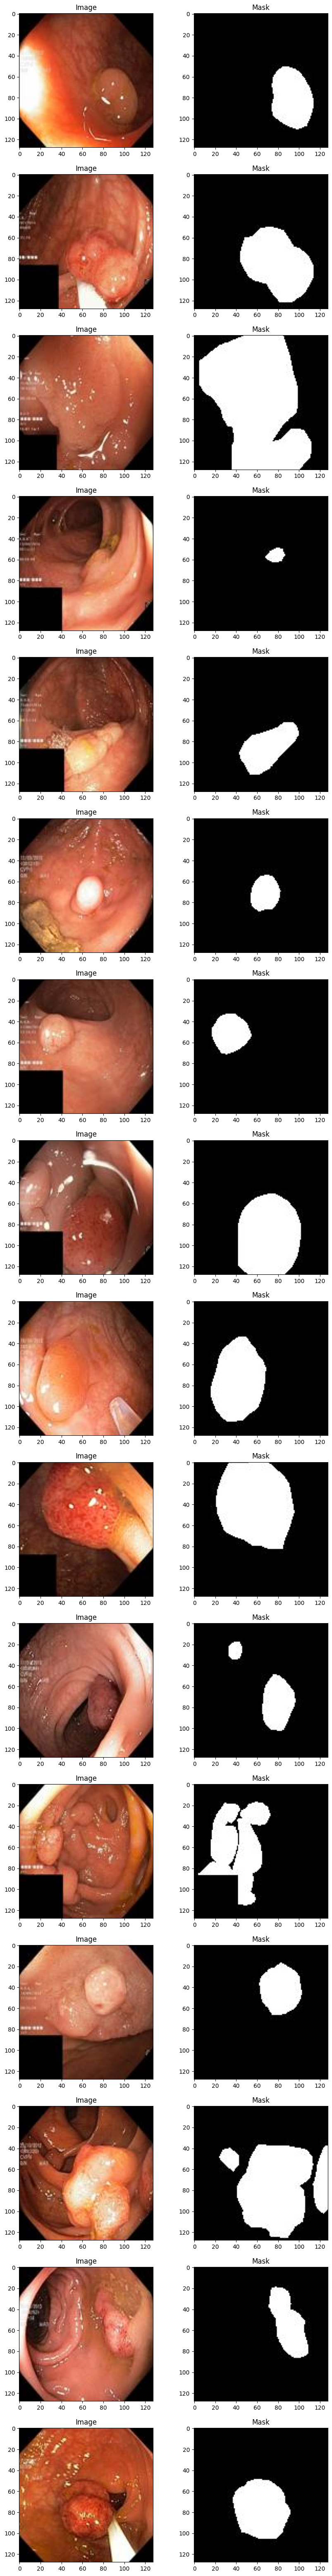

In [12]:
# plot the images and masks
def plot_images_and_masks(images, masks):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    for i in range(num_images):
        axs[i, 0].imshow(images[i])
        axs[i, 0].set_title("Image")
        axs[i, 1].imshow(masks[i], cmap='gray')
        axs[i, 1].set_title("Mask")
    plt.show()
# Get a batch of images and masks
for images, masks in train_loader:
    plot_images_and_masks(images, masks)
    break

In [13]:
class UNet(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        # Final Convolution
        self.final_conv = torch.nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(torch.nn.functional.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(torch.nn.functional.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(torch.nn.functional.max_pool2d(enc3, kernel_size=2))

        # Bottleneck
        bottleneck = self.bottleneck(torch.nn.functional.max_pool2d(enc4, kernel_size=2))

        # Decoder
        up4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))

        up3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))

        up2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))

        up1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        # Final output
        return self.final_conv(dec1)
    
# Instantiate the model
model = UNet()
# move model to device
model.load_state_dict(torch.load('../baseline_models/base_line_segmentator.pth'))
model.to(device)
print(f"Model is on: {next(model.parameters()).device}")

/tmp/ipykernel_567617/3573598554.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../baseline_models/base_line_segmentator.pth'))


Model is on: cuda:0


In [14]:
# test model with a random input
x = torch.rand(1, 3, 128, 128).to(device)
y = model(x)
print(y)

tensor([[[[0.0212, 0.0111, 0.0021,  ..., 0.0119, 0.0104, 0.0363],
          [0.0211, 0.0085, 0.0043,  ..., 0.0098, 0.0104, 0.0297],
          [0.0169, 0.0069, 0.0062,  ..., 0.0133, 0.0104, 0.0278],
          ...,
          [0.0179, 0.0033, 0.0037,  ..., 0.0025, 0.0060, 0.0267],
          [0.0168, 0.0042, 0.0054,  ..., 0.0048, 0.0032, 0.0296],
          [0.0241, 0.0095, 0.0015,  ..., 0.0047, 0.0098, 0.0271]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)


In [15]:
y.shape

torch.Size([1, 1, 128, 128])

In [16]:
# test model with the first image from the train dataset
for i, (image, mask) in enumerate(train_loader):
    image = (image.permute(0, 3, 1, 2)/255).to(device)
    y = model(image)
    print(y.int())
    break

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        ...,


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
         

In [17]:
image[0].shape

torch.Size([3, 128, 128])

In [18]:
mask[0].shape

torch.Size([128, 128])

In [19]:
mask[0].max(), mask[0].min()

(tensor(1., dtype=torch.float64), tensor(0., dtype=torch.float64))

In [20]:
interpretabilities_dict = {}
interpretabilities_dict['ig'] = []
interpretabilities_dict['saliency'] = []
interpretabilities_dict['deep_lift'] = []

In [27]:
model.eval()
for i, (images, target_masks) in enumerate(test_loader):
    if i == 1:
        break
    # Integrated Gradients
    ig = IntegratedGradients(model)
    images = (images.permute(0, 3, 1, 2)/255).to(device)
    print(images.shape)
    attr_ig, delta_ig = ig.attribute(images, target=None, return_convergence_delta=True, internal_batch_size=10)
    # Saliency
    #saliency = Saliency(model)
    #attr_saliency = saliency.attribute(images, target=None)
    # DeepLift
    #dl = DeepLift(model)
    #attr_dl = dl.attribute(images, target=None)

    interpretabilities_dict['ig'].append(attr_ig)
    #interpretabilities_dict['saliency'].append(attr_saliency)
    #interpretabilities_dict['deep_lift'].append(attr_dl)

torch.Size([1, 3, 128, 128])


AssertionError: Target not provided when necessary, cannot take gradient with respect to multiple outputs.

In [ ]:
# plot the first 36 images and their interpretabilities
for i, (images, target_masks) in enumerate(test_loader):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 4, figsize=(20, 5 * num_images))
    for i in range(num_images):
        axs[i, 0].imshow(images[i])
        axs[i, 0].set_title("Image")
        axs[i, 1].imshow(interpretabilities_dict['ig'][i][0].detach().numpy(), cmap='gray')
        axs[i, 1].set_title("IG")
        axs[i, 2].imshow(interpretabilities_dict['saliency'][i][0].detach().numpy(), cmap='gray')
        axs[i, 2].set_title("Saliency")
        axs[i, 3].imshow(interpretabilities_dict['deep_lift'][i][0].detach().numpy(), cmap='gray')
        axs[i, 3].set_title("DeepLift")
    plt.show()

In [22]:
# test the model on the test dataset and calculate the mean iou
model.eval()
ious = torch.zeros(len(test_loader)).to(device)
masks_list = []
ious_list = []
images_list_mem = []
target_masks_list = []

for i, (images, target_masks) in enumerate(test_loader):
    if i < 36:
        images_list_mem.append(images)
        target_masks_list.append(target_masks)
    
    target_masks = target_masks.detach().numpy()
    images = images.to(device).permute(0, 3, 1, 2) / 255
    masks = model(images)
    if i < 36:
        masks_list.append(masks)

    masks = masks.detach().numpy()
    # 1. Compute Intersection over Union
    intersection = np.minimum(masks, target_masks).sum()
    union = np.maximum(masks, target_masks).sum()
    iou = intersection / union
    
    ious_list.append(iou)

In [23]:
# calculate the mean iou and the std of the ious
ious = torch.tensor(ious_list)
ious.mean(), ious.std(), ious.max(), ious.min(), ious.median()

(tensor(0.3883, dtype=torch.float64),
 tensor(0.2067, dtype=torch.float64),
 tensor(0.8461, dtype=torch.float64),
 tensor(3.8958e-05, dtype=torch.float64),
 tensor(0.3824, dtype=torch.float64))

In [24]:
masks_list[0][0].shape

torch.Size([1, 128, 128])

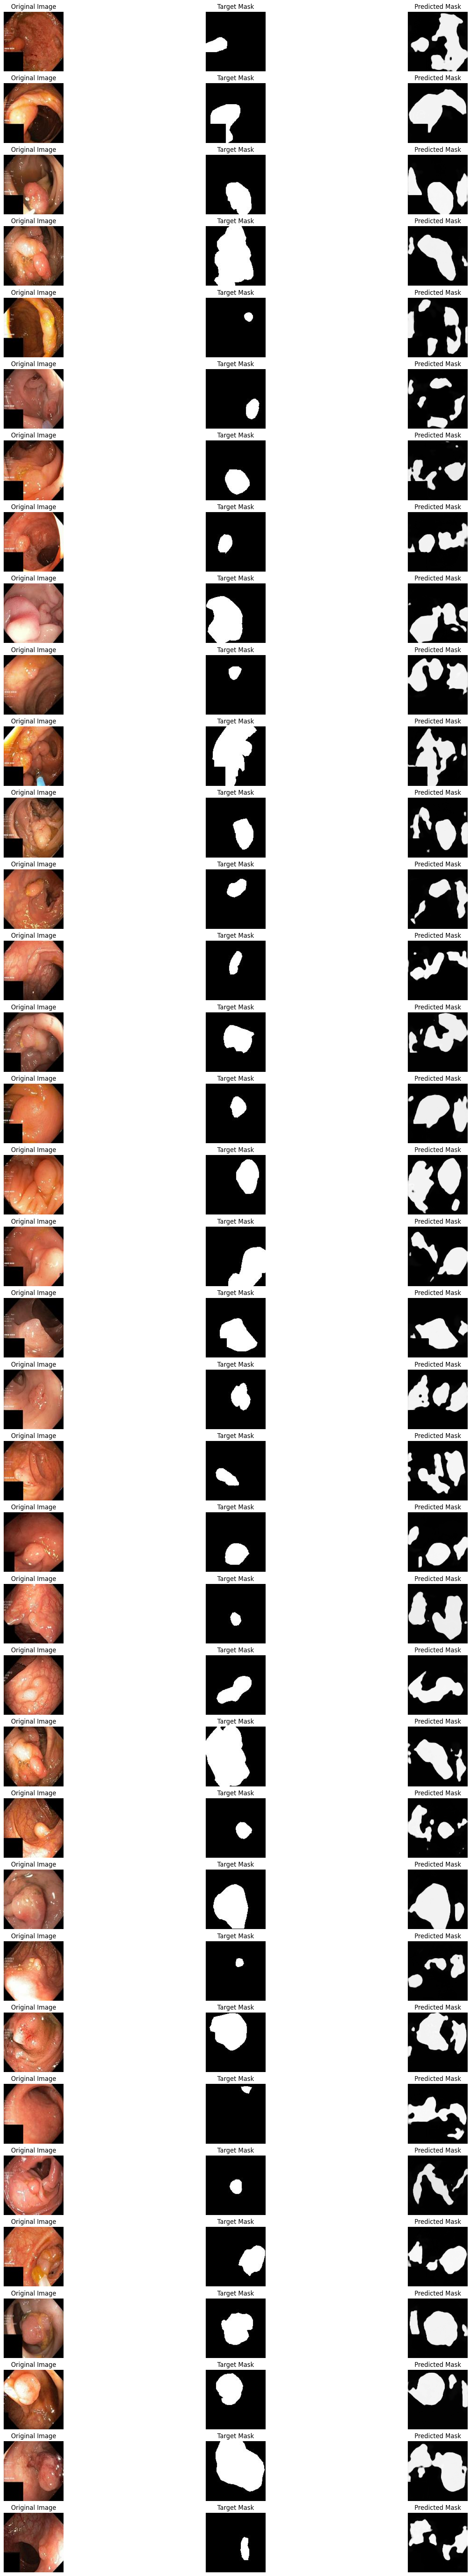

In [25]:
#visualize original images, prompt points, target masks and predicted masks of the test images
plt.figure(figsize=(20, 90))
# add title to the plot
for i in range(36):
    plt.subplot(36, 3, 3 * i + 1)
    plt.imshow(images_list_mem[i].squeeze(0))
    plt.title(f"Original Image")
    plt.axis("off")
    plt.subplot(36, 3, 3 * i + 2)
    plt.imshow(target_masks_list[i][0], cmap='gray')
    plt.title("Target Mask")
    plt.axis("off")
    plt.subplot(36, 3, 3 * i + 3)
    plt.imshow(masks_list[i][0][0].detach().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
plt.show()